In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [2]:
#check the data dimensions
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (200000, 202)
Test shape: (200000, 201)


In [3]:
# EDA
print(train.head())

   ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0

In [4]:
# Check for missing values
print("MISSING VALUES:")
train_missing = train.isnull().sum().sum()
test_missing = test.isnull().sum().sum()
print(f"Train total missing: {train_missing}")
print(f"Test total missing: {test_missing}")

MISSING VALUES:
Train total missing: 0
Test total missing: 0


In [5]:
if train_missing > 0:
    print("Train columns with missing values:")
    missing_cols = train.isnull().sum()
    print(missing_cols[missing_cols > 0])

if test_missing > 0:
    print("\nTest columns with missing values:")
    missing_cols = test.isnull().sum()
    print(missing_cols[missing_cols > 0])

# Filling in the missing values with median if any exists
if train_missing > 0 or test_missing > 0:
    print(" Filling missing values with median...")
    train.fillna(train.median(), inplace=True)
    test.fillna(test.median(), inplace=True)
    print(" Missing values filled")
else:
    print(" No missing values found")

 No missing values found


In [6]:
# Explore the data more

print("\nTARGET DISTRIBUTION:")
print(train['target'].value_counts())
print(f"Transaction rate: {train['target'].mean():.2%}") # percentage that made a transaction


TARGET DISTRIBUTION:
target
0    179902
1     20098
Name: count, dtype: int64
Transaction rate: 10.05%


In [17]:
#creating a dataset of just sales 

train_sale_subset = train[train["target"] == 1]

array([[<Axes: title={'center': 'target'}>,
        <Axes: title={'center': 'var_0'}>,
        <Axes: title={'center': 'var_1'}>,
        <Axes: title={'center': 'var_2'}>,
        <Axes: title={'center': 'var_3'}>,
        <Axes: title={'center': 'var_4'}>,
        <Axes: title={'center': 'var_5'}>,
        <Axes: title={'center': 'var_6'}>,
        <Axes: title={'center': 'var_7'}>,
        <Axes: title={'center': 'var_8'}>,
        <Axes: title={'center': 'var_9'}>,
        <Axes: title={'center': 'var_10'}>,
        <Axes: title={'center': 'var_11'}>,
        <Axes: title={'center': 'var_12'}>],
       [<Axes: title={'center': 'var_13'}>,
        <Axes: title={'center': 'var_14'}>,
        <Axes: title={'center': 'var_15'}>,
        <Axes: title={'center': 'var_16'}>,
        <Axes: title={'center': 'var_17'}>,
        <Axes: title={'center': 'var_18'}>,
        <Axes: title={'center': 'var_19'}>,
        <Axes: title={'center': 'var_20'}>,
        <Axes: title={'center': 'var_21'}

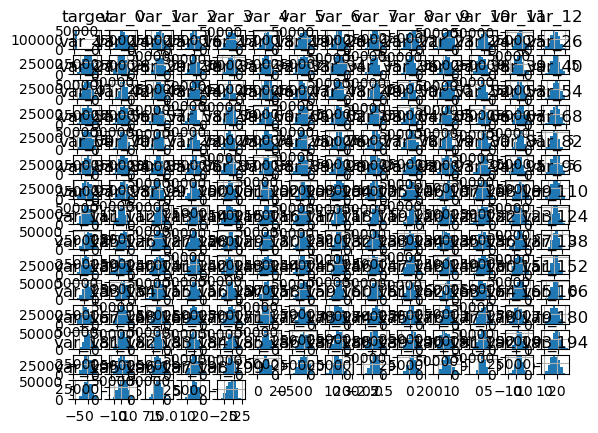

In [ ]:
#train.hist()

10% of people made a transaction. So we have to use AUC as a metric instead of accuracy score. 

In [7]:
train_ids = train['ID_code']
test_ids = test['ID_code']

In [8]:
# Separating features and target
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']
X_test = test.drop('ID_code', axis=1)

In [9]:
# Feature engineering

X['mean'] = X.mean(axis=1)
X['std'] = X.std(axis=1)
X['max'] = X.max(axis=1)
X['min'] = X.min(axis=1)


print(f"Original features: 200")
print(f"Features: {X.shape[1]}")
print(f"Added: mean, std, max, min")

Original features: 200
Features: 204
Added: mean, std, max, min


In [10]:
# Checking for correlation with target
correlations = pd.DataFrame(X).corrwith(y).abs().sort_values(ascending=False)
print("Top 20 features by correlation with target:")
print(correlations.head(20))

Top 20 features by correlation with target:
var_81     0.080917
var_139    0.074080
var_12     0.069489
var_6      0.066731
var_110    0.064275
var_146    0.063644
var_53     0.063399
var_26     0.062422
var_76     0.061917
var_174    0.061669
var_22     0.060558
var_21     0.058483
var_99     0.058367
var_166    0.057773
var_80     0.057609
var_190    0.055973
var_2      0.055870
var_165    0.055734
var_13     0.055156
var_148    0.055011
dtype: float64


The features above have the most correlation with the target variable.

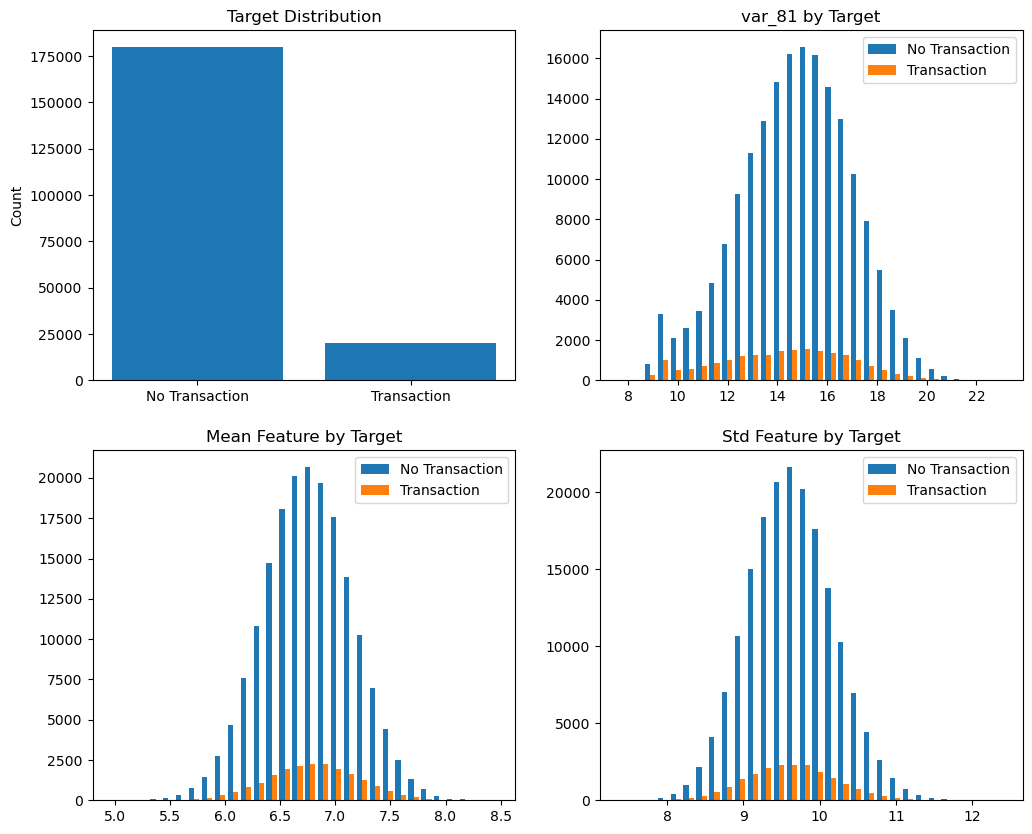

In [11]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Target distribution
axes[0, 0].bar(['No Transaction', 'Transaction'], y.value_counts().values)
axes[0, 0].set_title('Target Distribution')
axes[0, 0].set_ylabel('Count')

# Top correlated feature
top_feature = correlations.index[0]
axes[0, 1].hist([X[y==0][top_feature], X[y==1][top_feature]], 
                label=['No Transaction', 'Transaction'], bins=30)
axes[0, 1].set_title(f'{top_feature} by Target')
axes[0, 1].legend()


# Mean feature by target
axes[1, 0].hist([X[y==0]['mean'], X[y==1]['mean']], 
                label=['No Transaction', 'Transaction'], bins=30)
axes[1, 0].set_title('Mean Feature by Target')
axes[1, 0].legend()


# Stabdard deviation feature by target
axes[1, 1].hist([X[y==0]['std'], X[y==1]['std']], 
                label=['No Transaction', 'Transaction'], bins=30)
axes[1, 1].set_title('Std Feature by Target')
axes[1, 1].legend()

Text(0.5, 1.0, 'Correlation Heatmap - Top 10 Features')

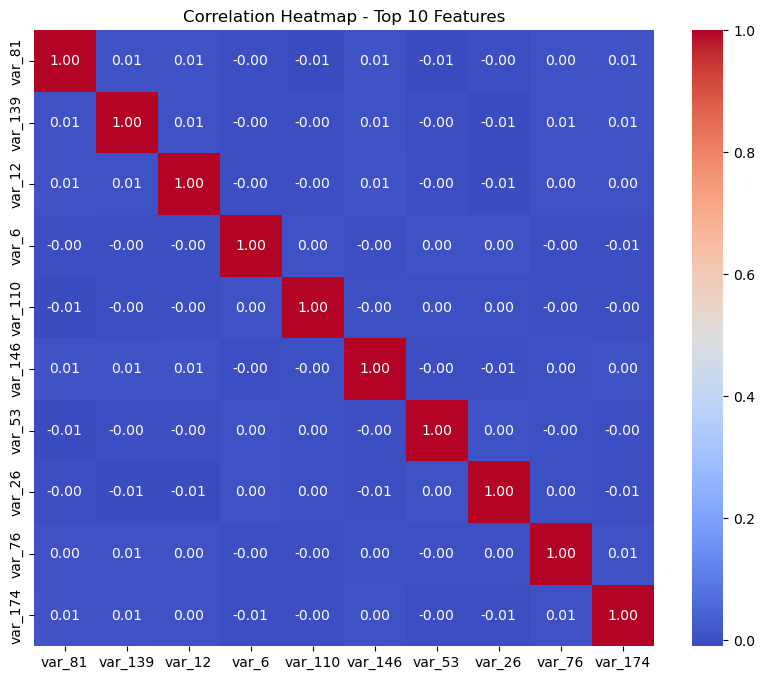

In [12]:
# Top features correlation heatmap
top_10 = correlations.head(10).index
corr_matrix = X[top_10].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap - Top 10 Features')

In [13]:
# Create pipeline with different scaling and PCA options
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")


# Using subset of data for faster results
subset_size = 10000  # Use only 10k samples for grid search
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, train_size=subset_size, random_state=42, stratify=y_train
)
print(f"\nUsing subset of {subset_size} samples for grid search")

Train set: 160000 samples
Validation set: 40000 samples

Using subset of 10000 samples for grid search


In [25]:
#might want to rename this later?

preprocessing_pipe = Pipeline([
    ('scaler', StandardScaler()),  # Will be replaced in grid search
    ('pca', PCA()),  # Will be replaced in grid search
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Define parameter grid
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'pca__n_components': [None, 5, 10, 25, 50, 100],
    'model__C': [0.1, 1]
}


In [27]:
# Grid search on subset
grid_search = GridSearchCV(
    preprocessing_pipe, 
    param_grid, 
    cv=3,  
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

In [28]:

grid_search.fit(X_train_subset, y_train_subset)

print(f"\nBest parameters:")
print(grid_search.best_params_)
print(f"\nBest CV AUC: {grid_search.best_score_:.4f}")

# Evaluate on validation set full
val_auc = roc_auc_score(y_val, grid_search.predict_proba(X_val)[:, 1])
print(f"Validation AUC: {val_auc:.4f}")

# Save best preprocessing pipeline
best_preprocessing = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters:
{'model__C': 1, 'pca__n_components': None, 'scaler': None}

Best CV AUC: 0.8381
Validation AUC: 0.8495


In [24]:
#Trying a Decision Tree Classifier 
#Based off code from my (Mia's) lab 11, and Aarya's code above 

tree_pipe = Pipeline([
    ('scaler', StandardScaler()),  
    ('pca', PCA()),
    ('model', DecisionTreeClassifier())
])

tree_parms = {
    'model__max_depth': [2,3,4],
    'model__min_samples_split': [10,20,40],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'pca__n_components': [None, 5, 10, 25, 50, 100]
}

tree_grid_res = GridSearchCV(
    estimator = tree_pipe, 
    param_grid = tree_parms, 
    cv=5, 
    scoring = 'roc_auc').fit(X_train_subset, y_train_subset)

print(tree_grid_res.best_estimator_)
print(tree_grid_res.best_score_)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('model',
                 DecisionTreeClassifier(max_depth=4, min_samples_split=10))])
0.7482958333333334
